In [1]:
import numpy as np
import pandas as pd
from skimage import io
import matplotlib
import matplotlib.pyplot as plt
import os
import time
import csv
from glob import glob
import torch
import torch.nn as nn
from tqdm import tqdm
from PIL import Image
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from transformers import EfficientNetImageProcessor, EfficientNetForImageClassification, get_scheduler
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sns
#from network import Net
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
if not os.path.exists('./outputs'):
    os.mkdir('./outputs')

/home/dungle/anaconda3/envs/EfficientViT-Microsoft/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# Global parameters
USE_CUDA = torch.cuda.is_available()
DATASET_PATH =  '/home/sentry-ws01/Documents/EuroSat_Satellite/EuroSAT_RGB' #'/home/sentry-ws01/Documents/EuroSat_Satellite/EuroSAT_RGB'   'C:\\Users\\thanh-dung.le\\Documents\\EuroSat_Satellite\\EuroSAT_RGB'
BATCH_SIZE = 64
NUM_EPOCHS = 100
LEARNING_RATE = 0.00015
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0005

# Check train and test directories
train_path = os.path.join(DATASET_PATH, 'train')
print(f"Train directory exists: {os.path.exists(train_path)}")
print(f"Classes in train directory: {os.listdir(train_path)}")
test_path = os.path.join(DATASET_PATH, 'test')
print(f"Test directory exists: {os.path.exists(test_path)}")
print(f"Classes in test directory: {os.listdir(test_path)}")


data_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),  # Randomly flip images
    transforms.RandomRotation(10),      # Randomly rotate images
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


# Datasets and DataLoaders
train_dataset = datasets.ImageFolder(os.path.join(DATASET_PATH, 'train'), data_transforms)
train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_dataset = datasets.ImageFolder(os.path.join(DATASET_PATH, 'test'), data_transforms)
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
class_names = train_dataset.classes

print('Dataloaders OK')

Train directory exists: True
Classes in train directory: ['Residential', 'AnnualCrop', 'SeaLake', 'Highway', 'River', 'PermanentCrop', 'Pasture', 'Industrial', 'HerbaceousVegetation', 'Forest']
Test directory exists: True
Classes in test directory: ['Residential', 'AnnualCrop', 'SeaLake', 'Highway', 'River', 'PermanentCrop', 'Pasture', 'Industrial', 'HerbaceousVegetation', 'Forest']
Dataloaders OK


Image label: 6


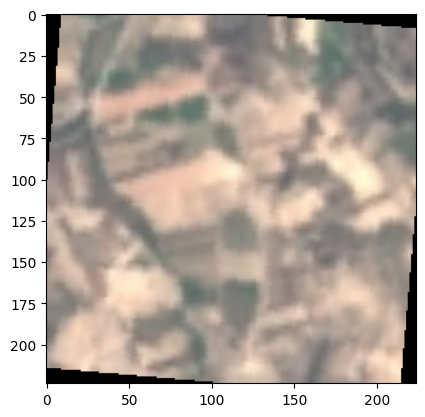

In [3]:
# Example data point visualization
random_image = train_dataset[13421][0].numpy().transpose((1, 2, 0))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
random_image = std * random_image + mean
random_image = np.clip(random_image, 0, 1)
print("Image label:", train_dataset[13421][1])
plt.imshow(random_image)
plt.show()

# Residual Network Architecture

In [4]:
#Create the model class with ResNet
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)

# Define the SE block
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(in_channels // reduction, in_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        se = x.mean((2, 3), keepdim=True)
        se = self.fc1(se)
        se = self.relu(se)
        se = self.fc2(se)
        se = self.sigmoid(se)
        return x * se

# Define the Gated SE block
class GatedSEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(GatedSEBlock, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(in_channels // reduction, in_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
        self.gate = nn.Conv2d(in_channels, in_channels, kernel_size=1)

    def forward(self, x):
        se = self.global_avg_pool(x)
        se = self.fc1(se)
        se = self.relu(se)
        se = self.fc2(se)
        se = self.sigmoid(se)
        gated_se = self.gate(se)
        gated_se = self.sigmoid(gated_se)
        return x * gated_se
    
class EnhancedGatedSEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(EnhancedGatedSEBlock, self).__init__()
        # Original Squeeze-and-Excitation part
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(in_channels // reduction, in_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
        
        # Gated mechanism with GLU adaptation
        self.gate_linear = nn.Conv2d(in_channels, in_channels, kernel_size=1)  # Linear path
        self.gate_sigmoid = nn.Conv2d(in_channels, in_channels, kernel_size=1)  # Gate path

    def forward(self, x):
        # Squeeze-and-Excitation recalibration
        se = self.global_avg_pool(x)
        se = self.fc1(se)
        se = self.relu(se)
        se = self.fc2(se)
        se = self.sigmoid(se)  # Produces weights for each channel

        # Gated mechanism (GLU adaptation)
        gate_linear_out = self.gate_linear(x)
        gate_sigmoid_out = torch.sigmoid(self.gate_sigmoid(x))  # Produces gating weights

        # Element-wise multiplication (GLU-style gating)
        gated_se = gate_linear_out * gate_sigmoid_out

        # Apply recalibration from SE step
        out = x * se
        out = out + gated_se  # Combining the recalibrated output and the GLU-enhanced output

        return out

In [5]:
# Define the modified ResidualBlock with optional SE, Gated SE, or Enhanced Gated SE block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, block_type='plain'):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.block_type = block_type
        if block_type == 'se':
            self.se = SEBlock(out_channels)
        elif block_type == 'gated_se':
            self.se = GatedSEBlock(out_channels)
        elif block_type == 'enhanced_gated_se':
            self.se = EnhancedGatedSEBlock(out_channels)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        if self.block_type in ['se', 'gated_se', 'enhanced_gated_se']:
            out = self.se(out)
        out = self.relu(out)
        return out

In [6]:
# Define the ResNet model with options for SE, Gated SE, or Enhanced Gated SE blocks
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10, block_type='plain'):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0], 1, block_type)
        self.layer2 = self.make_layer(block, 32, layers[1], 2, block_type)
        self.layer3 = self.make_layer(block, 64, layers[2], 2, block_type)
        self.avg_pool = nn.AdaptiveAvgPool2d(3)  # Pool to 3x3 feature map
        self.fc = nn.Linear(64 * 3 * 3, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1, block_type='plain'):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(conv3x3(self.in_channels, out_channels, stride=stride),
                                       nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample, block_type))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels, block_type=block_type))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(x.size(0), -1)
        out = self.fc(out)
        return out

# Create models

In [7]:
# Function to create a specific model based on type and complexity
def create_model(model_type, version, num_classes=10):
    layer_configs = {
        'ResNet-8': [1, 1, 1],
        'ResNet-16': [2, 2, 2],
        'ResNet-32': [5, 5, 5],
        'ResNet-50': [8, 8, 8]
    }
    layers = layer_configs[version]
    if model_type == 'plain':
        return ResNet(ResidualBlock, layers, num_classes, block_type='plain')
    elif model_type == 'se':
        return ResNet(ResidualBlock, layers, num_classes, block_type='se')
    elif model_type == 'gated_se':
        return ResNet(ResidualBlock, layers, num_classes, block_type='gated_se')
    elif model_type == 'enhanced_gated_se':
        return ResNet(ResidualBlock, layers, num_classes, block_type='enhanced_gated_se')
    else:
        raise ValueError("Unknown model type")

In [8]:
# Define the path where the teacher model
teacher_1_model_path = './outputs/EfficientViT_M2.pth'

# Load the teacher model (EfficientViT-M5)
from classification.model.build import EfficientViT_M2
model_teacher_1 = EfficientViT_M2(pretrained='efficientvit_m2')
model_teacher_1.head.l = nn.Linear(model_teacher_1.head.l.in_features, len(class_names))

# Load the state dictionary
model_teacher_1.load_state_dict(torch.load(teacher_1_model_path))

/tmp/ipykernel_2621310/1280534658.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_teacher_1.load_state_dict(torch.load(teacher_1_model_path))


<All keys matched successfully>

In [9]:
from transformers import AutoImageProcessor, MobileViTV2ForImageClassification
# Define the path where the teacher model
teacher_2_model_path = './outputs/MobileViT2.pth'

# Load the teacher model (MobileViT)
teacher_2_model_name = "apple/mobilevitv2-1.0-imagenet1k-256"
feature_extractor = AutoImageProcessor.from_pretrained(teacher_2_model_name)
model_teacher_2 = MobileViTV2ForImageClassification.from_pretrained(teacher_2_model_name)

# Modify the classifier to match the number of classes
model_teacher_2.classifier = nn.Linear(model_teacher_2.classifier.in_features, len(class_names))

# Load the state dictionary
model_teacher_2.load_state_dict(torch.load(teacher_2_model_path))

/tmp/ipykernel_2621310/1659941987.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_teacher_2.load_state_dict(torch.load(teacher_2_model_path))


<All keys matched successfully>

In [10]:

class DistillationLoss(nn.Module):
    def __init__(self, temperature=2.0, threshold=0.6, min_weight=0.1):
        super(DistillationLoss, self).__init__()
        self.temperature = temperature
        self.threshold = threshold
        self.min_weight = min_weight
        self.criterion_CE = nn.CrossEntropyLoss()
        self.criterion_KL = nn.KLDivLoss(reduction='batchmean')

    def forward(self, student_outputs, teacher_outputs_1, teacher_outputs_2, labels):
        # Soft labels from both teachers (logits with temperature scaling)
        teacher_probs_1 = torch.softmax(teacher_outputs_1 / self.temperature, dim=1)
        teacher_probs_2 = torch.softmax(teacher_outputs_2 / self.temperature, dim=1)
        student_probs = torch.log_softmax(student_outputs / self.temperature, dim=1)

        # Calculate confidence for both teachers (maximum probability as confidence)
        confidence_1 = teacher_probs_1.max(dim=1)[0].mean().item()
        confidence_2 = teacher_probs_2.max(dim=1)[0].mean().item()

        # Dynamically adjust alpha and beta based on confidence
        # Define threshold
        threshold = 0.6

        # Case 1: Both teachers are highly unreliable (far below threshold)
        if confidence_1 < 0.4 and confidence_2 < 0.4:
            alpha, beta = 0.0, 0.0  # Ignore both teachers

        # Case 2: Both teachers have low confidence but may provide some useful information
        elif confidence_1 < threshold and confidence_2 < threshold:
        # Set a reduced weight for both teachers, but still use them
            alpha = max(0.5 - (threshold - confidence_1), 0.1)
            beta = max(0.5 - (threshold - confidence_2), 0.1)

        # If only one teacher is below the threshold, adjust as before
        elif confidence_1 < threshold:
            alpha, beta = 0.3, 0.7  # Reduce alpha, increase beta
        elif confidence_2 < threshold:
            alpha, beta = 0.7, 0.3  # Reduce beta, increase alpha

        # Else case when both teachers have sufficient confidence
        else:
            alpha, beta = 0.5, 0.5  # Equal weighting if both confident enough

        # Cross-Entropy Loss (between student and true labels)
        loss_CE = self.criterion_CE(student_outputs, labels)
        
        # KL-Divergence Loss for both teachers
        loss_KL_1 = self.criterion_KL(student_probs, teacher_probs_1)
        loss_KL_2 = self.criterion_KL(student_probs, teacher_probs_2)

        # Total KL loss is a weighted sum of the two KL losses
        loss_KL = alpha * loss_KL_1 + beta * loss_KL_2

        # Total loss is a combination of cross-entropy and KL divergence loss
        loss = (1 - (alpha + beta) / 2) * loss_CE + (alpha + beta) / 2 * loss_KL * (self.temperature ** 2)
        return loss

In [11]:
if USE_CUDA:
    model_teacher_1 = model_teacher_1.cuda()
    model_teacher_2 = model_teacher_2.cuda()
    
print('Network OK for training')

Network OK for training




Running epoch 1 of 100 for model type plain...



/home/dungle/anaconda3/envs/EfficientViT-Microsoft/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1 Training: Average Loss=2.7000 | Accuracy=57.27%
Epoch 1 Evaluation: Average Loss=1.0285 | Accuracy=64.91%
New best model saved for plain at epoch 1 with accuracy 64.91%


Running epoch 2 of 100 for model type plain...

Epoch 2 Training: Average Loss=2.1209 | Accuracy=67.97%
Epoch 2 Evaluation: Average Loss=0.8773 | Accuracy=71.72%
New best model saved for plain at epoch 2 with accuracy 71.72%


Running epoch 3 of 100 for model type plain...

Epoch 3 Training: Average Loss=1.9540 | Accuracy=71.58%
Epoch 3 Evaluation: Average Loss=0.7690 | Accuracy=73.57%
New best model saved for plain at epoch 3 with accuracy 73.57%


Running epoch 4 of 100 for model type plain...

Epoch 4 Training: Average Loss=1.7990 | Accuracy=74.37%
Epoch 4 Evaluation: Average Loss=0.8670 | Accuracy=73.78%
New best model saved for plain at epoch 4 with accuracy 73.78%


Running epoch 5 of 100 for model type plain...

Epoch 5 Training: Average Loss=1.6482 | Accuracy=77.37%
Epoch 5 Evaluation: Average Loss=0.6

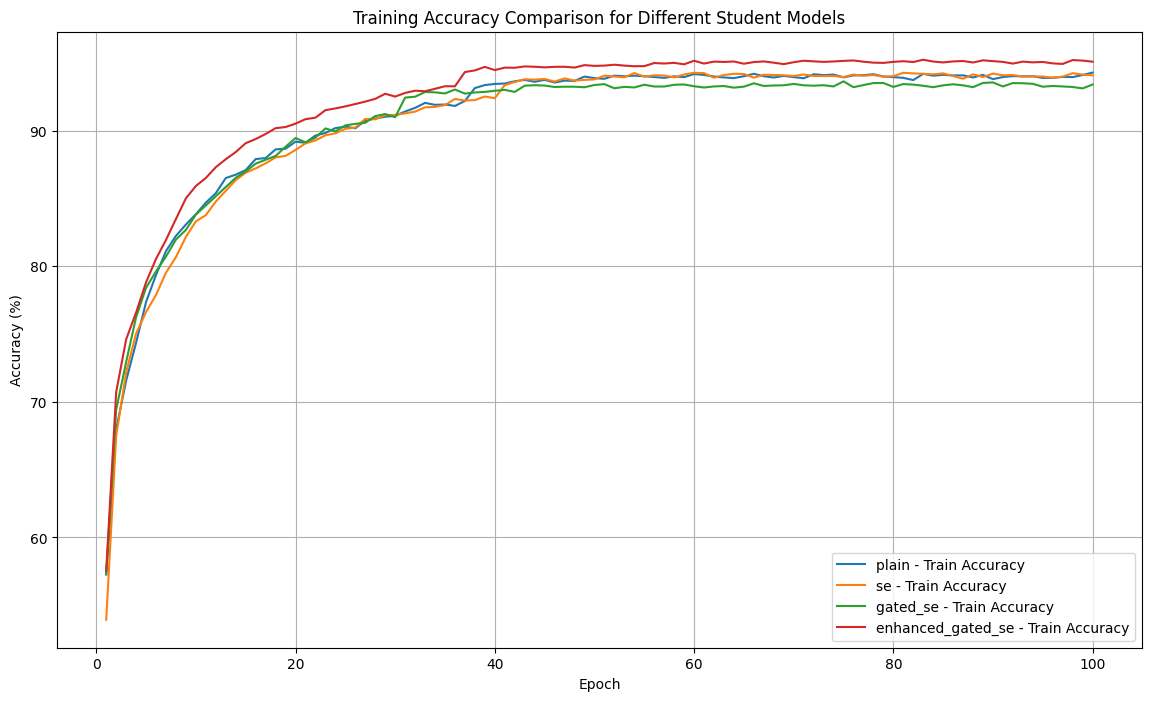

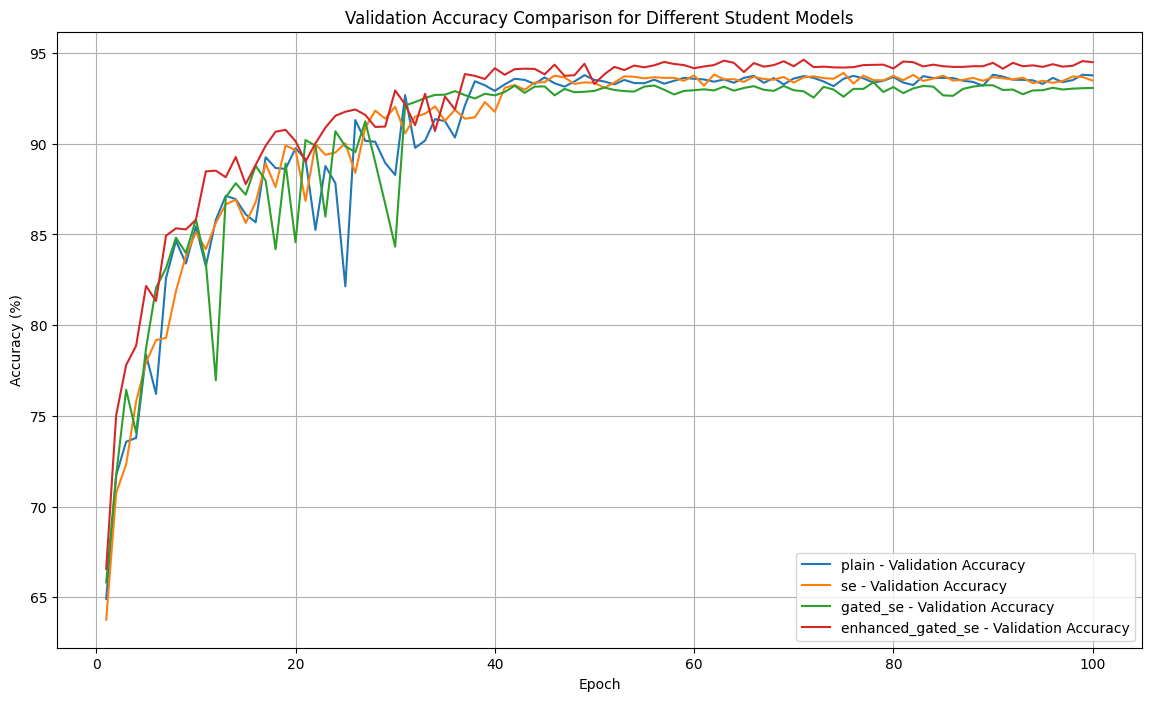

In [12]:
# Define the four different student model types
student_model_types = ['plain', 'se', 'gated_se', 'enhanced_gated_se']
model_versions = ['ResNet-8']

# Lists to store overall performance metrics for all models
train_accuracies_all = {}
test_accuracies_all = {}
train_losses_all = {}
test_losses_all = {}

# Iterate over each student model type and perform dual teacher training
for model_type in student_model_types:
    # Create the student model
    model_student = create_model(model_type, model_versions[0], num_classes=len(class_names))

    if USE_CUDA:
        model_student = model_student.cuda()

    # Initialize lists to track performance over epochs
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    epochs = []

    # To track the best model checkpoint
    best_accuracy = 0.0
    best_model_path = f'./outputs/{model_type}_best_epoch_100.pth'

    # Define the criterion, optimizer, and scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model_student.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
    distillation_loss_fn = DistillationLoss(temperature=5.0, threshold=0.6, min_weight=0.1)

    # Training and Evaluation loop
    for epoch in range(1, NUM_EPOCHS + 1):
        print(f'\n\nRunning epoch {epoch} of {NUM_EPOCHS} for model type {model_type}...\n')
        epochs.append(epoch)

        # Training Phase
        model_student.train()
        model_teacher_1.eval()
        model_teacher_2.eval()

        train_loss = 0.0
        train_correct = 0
        train_total = 0
        iterations = 0

        for inputs, labels in train_loader:
            if USE_CUDA:
                inputs, labels = inputs.cuda(), labels.cuda()

            # Get outputs from both teachers
            with torch.no_grad():
                teacher_outputs_1 = model_teacher_1(inputs)
                teacher_outputs_2 = model_teacher_2(inputs).logits

            # Get the student's outputs
            student_outputs = model_student(inputs)

            # Compute the distillation loss with dual teachers
            loss = distillation_loss_fn(student_outputs, teacher_outputs_1, teacher_outputs_2, labels)

            # Backpropagation and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track loss and accuracy
            train_loss += loss.item()
            _, predicted = torch.max(student_outputs, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)
            iterations += 1

        avg_train_loss = train_loss / iterations
        train_accuracy = 100.0 * train_correct / train_total

        # Store loss and accuracy
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        print(f'Epoch {epoch} Training: Average Loss={avg_train_loss:.4f} | Accuracy={train_accuracy:.2f}%')

        # Evaluation Phase
        model_student.eval()
        test_loss = 0.0
        test_correct = 0
        test_total = 0
        iterations = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                if USE_CUDA:
                    inputs, labels = inputs.cuda(), labels.cuda()

                # Get the student's outputs
                student_outputs = model_student(inputs)

                # Compute the standard cross-entropy loss (evaluation)
                loss = criterion(student_outputs, labels)
                test_loss += loss.item()

                # Track accuracy
                _, predicted = torch.max(student_outputs, 1)
                test_correct += (predicted == labels).sum().item()
                test_total += labels.size(0)
                iterations += 1

        avg_test_loss = test_loss / iterations
        test_accuracy = 100.0 * test_correct / test_total

        # Update scheduler
        scheduler.step(avg_test_loss)

        # Store loss and accuracy
        test_losses.append(avg_test_loss)
        test_accuracies.append(test_accuracy)

        print(f'Epoch {epoch} Evaluation: Average Loss={avg_test_loss:.4f} | Accuracy={test_accuracy:.2f}%')

        # Save the model if it has the highest accuracy
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            torch.save(model_student.state_dict(), best_model_path)
            print(f'New best model saved for {model_type} at epoch {epoch} with accuracy {best_accuracy:.2f}%')

    # Save the results to a CSV file
    csv_file_path = f'./outputs/{model_type}_experiment_results_100.csv'
    with open(csv_file_path, 'w', newline='') as output_file:
        dict_writer = csv.DictWriter(output_file, fieldnames=['Epoch', 'Train Loss', 'Train Accuracy', 'Test Loss', 'Test Accuracy'])
        dict_writer.writeheader()
        for epoch in range(NUM_EPOCHS):
            dict_writer.writerow({
                'Epoch': epoch + 1,
                'Train Loss': train_losses[epoch],
                'Train Accuracy': train_accuracies[epoch],
                'Test Loss': test_losses[epoch],
                'Test Accuracy': test_accuracies[epoch]
            })
    print(f"Experiment results saved for {model_type} to {csv_file_path}")

    # Store the performance metrics for comparison
    train_accuracies_all[model_type] = train_accuracies
    test_accuracies_all[model_type] = test_accuracies
    train_losses_all[model_type] = train_losses
    test_losses_all[model_type] = test_losses

# Plotting the comparison of accuracy over epochs for all student models
plt.figure(figsize=(14, 8))

# Plot train accuracies
for model_type in student_model_types:
    plt.plot(range(1, NUM_EPOCHS + 1), train_accuracies_all[model_type], label=f'{model_type} - Train Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy Comparison for Different Student Models')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(14, 8))

# Plot test accuracies
for model_type in student_model_types:
    plt.plot(range(1, NUM_EPOCHS + 1), test_accuracies_all[model_type], label=f'{model_type} - Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Comparison for Different Student Models')
plt.legend()
plt.grid()
plt.show()